# Connect to Mongo Atlas

This needs the following variables in `.env` file.  Replace `ATLAS_URI`, you can get this value from your atlas UI.


```text
ATLAS_URI=mongodb+srv://<username>:<password>@sandbox.lqlql.mongodb.net/?retryWrites=true&w=majority
DB_NAME=sample_mflix
```

References

- https://www.mongodb.com/developer/products/atlas/semantic-search-mongodb-atlas-vector-search/
- https://www.mongodb.com/languages/python/pymongo-tutorial
- https://cookbook.openai.com/examples/vector_databases/mongodb_atlas/semantic_search_using_mongodb_atlas_vector_search

In [1]:
import os, sys
import pprint
import json
import time

In [2]:
## Load Settings from .env file
from dotenv import find_dotenv, dotenv_values

# _ = load_dotenv(find_dotenv()) # read local .env file
config = dotenv_values(find_dotenv())

# debug
# print (config)

ATLAS_URI = config.get('ATLAS_URI')
DB_NAME = config.get ('DB_NAME')
OPENAI_API_KEY = config.get("OPENAI_API_KEY")

if not ATLAS_URI:
    raise Exception ("'ATLAS_URI' is not set.  Please set it above to continue...")

if not DB_NAME:
    raise Exception ("'DB_NAME' is not set.  Please set it above to continue...")

if not OPENAI_API_KEY:
    raise Exception ("'OPENAI_API_KEY' is not set.  Please set it above to continue...")

## Find My Public IP

This IP address should be added to Atlas's 'access list' for the connection to work

In [3]:
# import requests
# ip = requests.get('https://api.ipify.org').text()

from urllib.request import urlopen
ip = urlopen('https://api.ipify.org').read()
print ("public IP is : ", ip)

public IP is :  b'67.160.193.201'


## Establish Connection

In [4]:
# Connect to Mongo

from pymongo import MongoClient

mongodb_client = MongoClient(ATLAS_URI)
database = mongodb_client[DB_NAME]
collection = database["embedded_movies"]
print("Connected to the MongoDB database!")

Connected to the MongoDB database!


## Couple of Queries

In [20]:
## Query some data

movies = list(collection.find(limit=10))
print (f"Found {len (movies)} movies")
# pprint.pprint (movies, indent=4)

for idx, movie in enumerate (movies):
    print(f'{idx+1}\nid: {movie["_id"]}\ntitle: {movie["title"]},\nyear: {movie["year"]}\nplot: {movie["plot"]}\n')

Found 10 movies
1
id: 573a1390f29313caabcd5293
title: The Perils of Pauline,
year: 1914
plot: Young Pauline is left a lot of money when her wealthy uncle dies. However, her uncle's secretary has been named as her guardian until she marries, at which time she will officially take ...

2
id: 573a1391f29313caabcd68d0
title: From Hand to Mouth,
year: 1919
plot: A penniless young man tries to save an heiress from kidnappers and help her secure her inheritance.

3
id: 573a1391f29313caabcd820b
title: Beau Geste,
year: 1926
plot: Michael "Beau" Geste leaves England in disgrace and joins the infamous French Foreign Legion. He is reunited with his two brothers in North Africa, where they face greater danger from their...

4
id: 573a1391f29313caabcd8268
title: The Black Pirate,
year: 1926
plot: Seeking revenge, an athletic young man joins the pirate band responsible for his father's death.

5
id: 573a1391f29313caabcd8319
title: For Heaven's Sake,
year: 1926
plot: An irresponsible young millionair

In [19]:
## Find by year

movies = list(collection.find({"year": 1999}, limit=10))

print (f"Found {len (movies)} movies")

for idx, movie in enumerate (movies):
    print(f'{idx+1}\nid: {movie["_id"]}\ntitle: {movie["title"]},\nyear: {movie["year"]}\nplot: {movie["plot"]}\n')

Found 10 movies
1
id: 573a139af29313caabcf0cfd
title: Three Kings,
year: 1999
plot: In the aftermath of the Persian Gulf War, 4 soldiers set out to steal gold that was stolen from Kuwait, but they discover people who desperately need their help.

2
id: 573a139af29313caabcf0e61
title: Beowulf,
year: 1999
plot: A sci-fi update of the famous 6th Century poem. In a beseiged land, Beowulf must battle against the hideous creature Grendel and his vengeance seeking mother.

3
id: 573a139af29313caabcf0e6c
title: The Mummy,
year: 1999
plot: An American serving in the French Foreign Legion on an archaeological dig at the ancient city of Hamunaptra accidentally awakens a Mummy.

4
id: 573a139af29313caabcf0e95
title: The 13th Warrior,
year: 1999
plot: A man, having fallen in love with the wrong woman, is sent by the sultan himself on a diplomatic mission to a distant land as an ambassador. Stopping at a Viking village port to restock on supplies, he finds himself unwittingly embroiled on a quest to

## OpenAI Client for Embeddings

In [7]:
## Initialize OpenAI
from openai import OpenAI

client = OpenAI(
    # defaults to os.environ.get("OPENAI_API_KEY")
    api_key= OPENAI_API_KEY,
)
print ("OpenAI Client initialized!")

# https://platform.openai.com/docs/guides/embeddings/what-are-embeddings

def get_embedding(text: str,  model="text-embedding-ada-002") -> list[float]:
    text = text.replace("\n", " ")
    resp = client.embeddings.create (
		input=[text],
		model=model  )

    return resp.data[0].embedding

OpenAI Client initialized!


## Try a Quick Embedding Test

In [8]:
## Search by embeddings

plot = 'a futuristic Sci-fi movie'

embedding = get_embedding (plot)
print (f"Embedding for text='{plot}', embeddding_length={len(embedding)}, printing first few numbers... :\n", embedding [:10] )


Embedding for text='a futuristic Sci-fi movie', embeddding_length=1536, printing first few numbers... :
 [-0.008840689435601234, -0.034085843712091446, -0.011264224536716938, -0.030672045424580574, 0.009133859537541866, 0.015166636556386948, -0.021590305492281914, -0.027388548478484154, -0.006205421406775713, -0.016391433775424957]


## Creating a Atlas Search Index

https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-tutorial/#create-the-atlas-vector-search-index

Index name: `idx_plot_embedding`

- Option-1 (preferred): Use the JSON snippet in Atlas UI
- Option-2: Use the python code below,

### Option-1 (preferred): Use the Following JSON snippet in Atlas UI

```json
{
  "type": "vectorSearch",
  "fields": [
    {
      "type": "vector",
      "path": "plot_embedding",
      "numDimensions": 1536,
      "similarity": "euclidean"
    }
  ]
}
```

Use these screenshots are guidelines.

Wait till the index is ready to be used

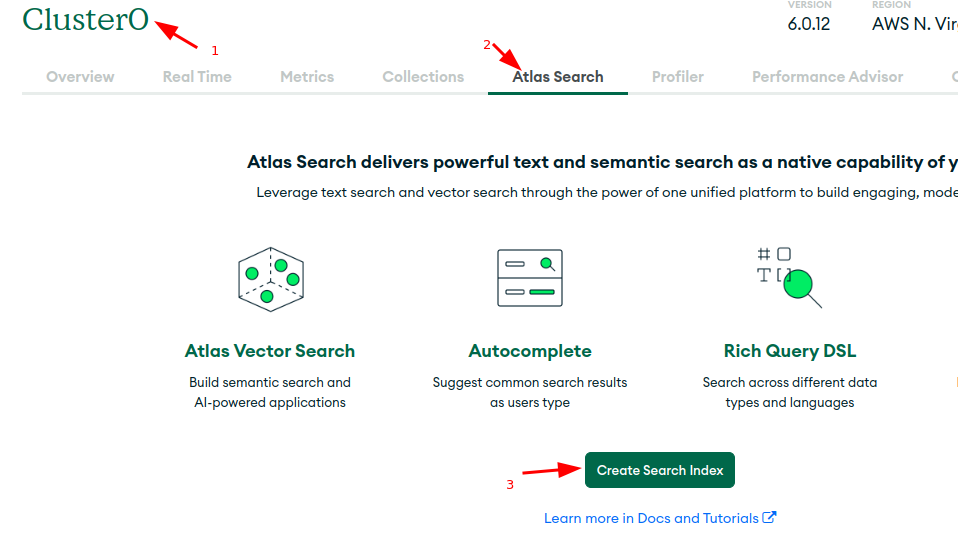

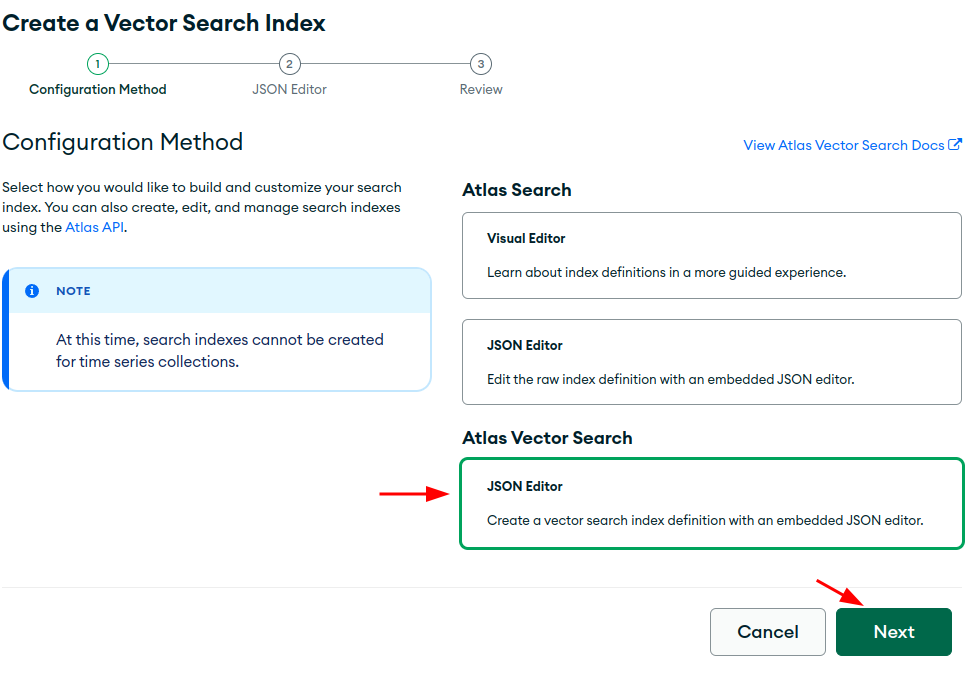

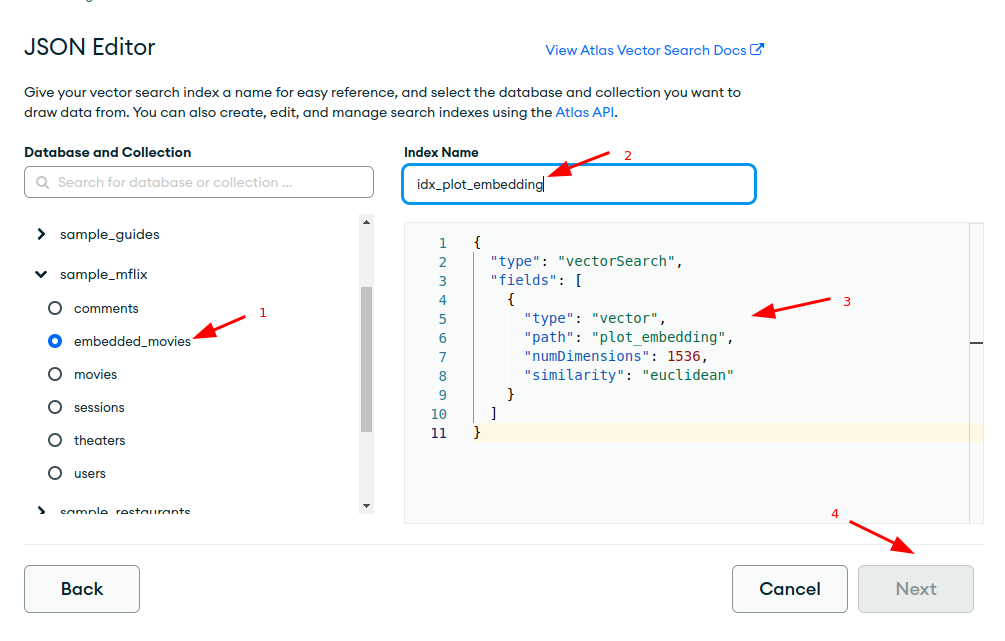

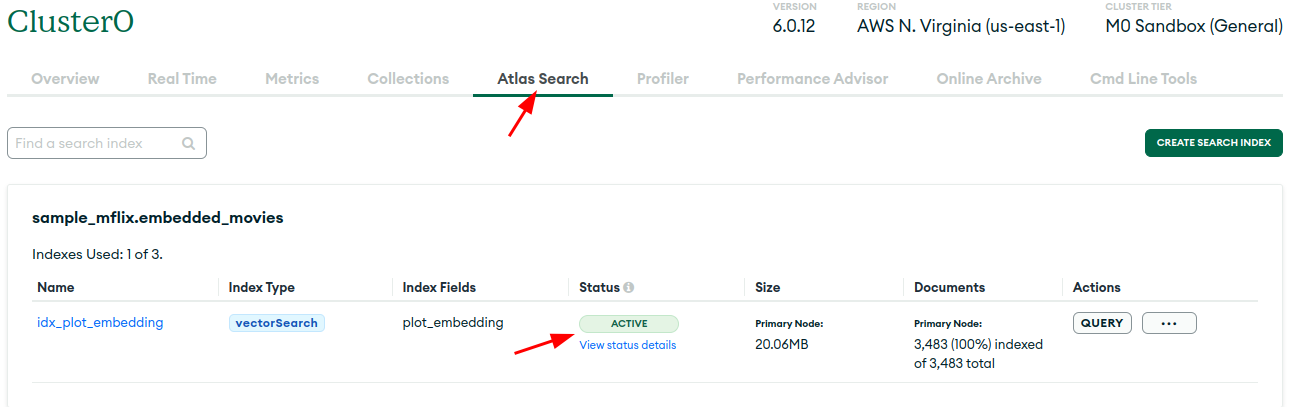



In [9]:
%%time

## Create a search index programatically

INDEX_NAME = 'idx_plot_embedding'

## TODO: fix this

# collection.create_search_index(
#     {"definition":
#         {"mappings": {"dynamic": True, "fields": {
#             'plot_embedding' : {
#                 "dimensions": 1536,
#                 "similarity": "dotProduct",
#                 "type": "knnVector"
#                 }}}},
#      "name": INDEX_NAME
#     }
# )

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10.3 µs


## Do an Embedding 

This is going to be fun.  We are going to query movies, not just on plot keywords but 'meaning'.

See the examples below.  And try your own!

In [10]:

def vector_search(query, limit=5):
  results = collection.aggregate([
    {
        '$vectorSearch': {
            "index": INDEX_NAME,
            "path": 'plot_embedding',
            "queryVector": get_embedding(query),
            "numCandidates": 50,
            "limit": limit,
        }
    }
    ])
  return results

In [21]:

query="imaginary characters from outerspace at war with earthlings"

movies = list(vector_search(query, 5))
print (f"Found {len (movies)} movies")
for idx, movie in enumerate (movies):
    print(f'{idx+1}\nid: {movie["_id"]}\ntitle: {movie["title"]},\nyear: {movie["year"]}\nplot: {movie["plot"]}\n')

Found 5 movies
1
id: 573a1398f29313caabce8f83
title: V: The Final Battle,
year: 1984
plot: A small group of human resistance fighters fight a desperate guerilla war against the genocidal extra-terrestrials who dominate Earth.

2
id: 573a13d7f29313caabda215e
title: Pixels,
year: 2015
plot: When aliens misinterpret video feeds of classic arcade games as a declaration of war, they attack the Earth in the form of the video games.

3
id: 573a139ff29313caabd000f6
title: Battlefield Earth,
year: 2000
plot: After enslavement & near extermination by an alien race in the year 3000, humanity begins to fight back.

4
id: 573a13c7f29313caabd75324
title: Falling Skies,
year: 2011è
plot: Survivors of an alien attack on earth gather together to fight for their lives and fight back.

5
id: 573a13a9f29313caabd1e90b
title: Battlestar Galactica,
year: 2003
plot: A re-imagining of the original series in which a "rag-tag fugitive fleet" of the last remnants of mankind flees pursuing robots while simultaneou

In [22]:
query="Feel good sports movies"

movies = list(vector_search(query, 5))
print (f"Found {len (movies)} movies")
for idx, movie in enumerate (movies):
    print(f'{idx+1}\nid: {movie["_id"]}\ntitle: {movie["title"]},\nyear: {movie["year"]}\nplot: {movie["plot"]}\n')

Found 5 movies
1
id: 573a13a6f29313caabd17ce3
title: Shaolin Soccer,
year: 2001
plot: A young Shaolin follower reunites with his discouraged brothers to form a soccer team using their martial art skills to their advantage.

2
id: 573a139af29313caabcefe79
title: The Fan,
year: 1996
plot: An all star baseball player becomes the unhealthy focus of a down on his luck salesman.

3
id: 573a1397f29313caabce5d41
title: Rollerball,
year: 1975
plot: In a corporate-controlled future, an ultra-violent sport known as Rollerball represents the world, and one of its powerful athletes is out to defy those who want him out of the game.

4
id: 573a1399f29313caabcedcb0
title: Last Action Hero,
year: 1993
plot: With the help of a magic ticket, a young film fan is transported into the fictional world of his favorite action film character.

5
id: 573a1398f29313caabce9f6e
title: Shanghai Express,
year: 1986
plot: Multi-genre flick (western, martial arts, comedy, adventure, etc.) with an all-star cast about a

In [23]:
query="fatalistic sci-fi movies"

movies = list(vector_search(query, 5))
print (f"Found {len (movies)} movies")
for idx, movie in enumerate (movies):
    print(f'{idx+1}\nid: {movie["_id"]}\ntitle: {movie["title"]},\nyear: {movie["year"]}\nplot: {movie["plot"]}\n')

Found 5 movies
1
id: 573a139af29313caabcf0cff
title: Starship Troopers,
year: 1997
plot: Humans in a fascistic, militaristic future do battle with giant alien bugs in a fight for survival.

2
id: 573a139ff29313caabcff478
title: Terminator 3: Rise of the Machines,
year: 2003
plot: A cybernetic warrior from a post-apocalyptic future travels back in time to protect a 19-year old drifter and his future wife from a most advanced robotic assassin and to ensure they both survive a nuclear attack.

3
id: 573a1397f29313caabce61a5
title: Logan's Run,
year: 1976
plot: An idyllic sci-fi future has one major drawback: life must end at 30.

4
id: 573a13adf29313caabd2ae08
title: Starship Troopers 2: Hero of the Federation,
year: 2004
plot: In the sequel to Paul Verhoeven's loved/reviled sci-fi film, a group of troopers taking refuge in an abandoned outpost after fighting alien bugs, failing to realize that more danger lays in wait.

5
id: 573a13b5f29313caabd4473e
title: Wristcutters: A Love Story,
ye

### Try your own searches!

Update the query string to what ever you like, and run it

In [24]:
## TODO: enter your query here
query="???"

movies = list(vector_search(query, 5))
print (f"Found {len (movies)} movies")
for idx, movie in enumerate (movies):
    print(f'{idx+1}\nid: {movie["_id"]}\ntitle: {movie["title"]},\nyear: {movie["year"]}\nplot: {movie["plot"]}\n')

Found 5 movies
1
id: 573a13b1f29313caabd37bd3
title: Rampo Noir,
year: 2005
plot: Mars Canal - Within absolute silence, a naked man wanders through a dark and depressing landscape recalling the excruciating details of his last encounter with his former lover...

2
id: 573a1398f29313caabceacad
title: Amsterdamned,
year: 1988
plot: A mysterious diver hiding in Amsterdam's canal system embarks on a rampage of gruesome murders, terrifying city officials and leaving few clues for the city's best detective, who doesn't ...

3
id: 573a13b6f29313caabd48c52
title: Tales from Earthsea,
year: 2006
plot: In a mythical land, a man and a young boy investigate a series of unusual occurrences.

4
id: 573a13e8f29313caabdca460
title: The Nostalgist,
year: 2014
plot: In the futuristic city of Vanille, with properly tuned ImmerSyst Eyes & Ears the world can look and sound like a paradise. But the life of a father and his young son threatens to ...

5
id: 573a13d5f29313caabd9b905
title: Jellyfish Eyes,
yea

In [15]:
## Close connection

# mongodb_client.close()